### Importing Dependencies 

In [1]:
import numpy as np
import gymnasium as gym
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
import matplotlib.pyplot as plt
import random
import copy

from stable_baselines3.common.evaluation import evaluate_policy

# for Behaoivior cloning 
from imitation.algorithms import bc

### Creating the Environment 

In [2]:
env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(),
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],
)

### Creating the Expert 

In [3]:
expert = load_policy(
    "ppo-huggingface",
    organization="HumanCompatibleAI",
    env_name="seals/CartPole-v0",
    venv=env,
)

c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\kobbi\anaconda3\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


### Generating data for the training ( the transactions )

In [5]:
rng = np.random.default_rng() 

rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)

In [6]:
def get_transitions(rollouts, n):
    # n number of episodes used for the training  

    transitions = rollout.flatten_trajectories(rollouts[:n])
    return transitions

### Generation the corrupted data

In [7]:
def toggl_acts(rollouts, u):
    l =  len(rollouts)
    
    for i in range(l) :
        k = len(rollouts[i].acts)
        nbr_of_act = int(k * u)
        action_to_toggl = random.sample(range(k), nbr_of_act)
        rollouts[i].acts[action_to_toggl] = 1 - rollouts[i].acts[action_to_toggl]

In [8]:
rollouts_0 = copy.deepcopy(rollouts)
rollouts_5 = copy.deepcopy(rollouts)
rollouts_10 = copy.deepcopy(rollouts)
rollouts_20 = copy.deepcopy(rollouts)
rollouts_50 = copy.deepcopy(rollouts)

toggl_acts(rollouts_5, 0.05)
toggl_acts(rollouts_10, 0.1)
toggl_acts(rollouts_20, 0.2)
toggl_acts(rollouts_50, 0.5)

### Defining the trainer (policy: ActorCriticPolicy)

In [11]:
def create_trainer(env, transitions):
    return bc.BC(
        observation_space=env.observation_space,
        action_space=env.action_space,
        demonstrations=transitions,
        rng=rng,
        )

In [29]:
def create_BC_trainers(n) :
    return {0 : create_trainer(env, get_transitions(rollouts_0, n)),
              5 : create_trainer(env, get_transitions(rollouts_5, n)),
              10 : create_trainer(env, get_transitions(rollouts_10, n)),
              20 : create_trainer(env, get_transitions(rollouts_20, n)),
              50 : create_trainer(env, get_transitions(rollouts_50, n))
            }


In [233]:
N = [2, 4, 6, 8, 10]
trainers = [0, 5, 10, 20, 50]
rewards = []

RW = {0: [], 5: [], 10:[], 20:[], 50:[]}

for n in N:
    bc_trainers = create_BC_trainers(n)
    for trainer in trainers :

        bc_trainers[trainer].train( 
            n_epochs=20, 
            progress_bar= False, 
            on_epoch_end= lambda : rewards.append(evaluate_policy(bc_trainers[trainer].policy, env, 2)[0].mean()),
            log_interval=10000
            )
        
        RW[trainer].append(rewards)
        rewards = []

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size  

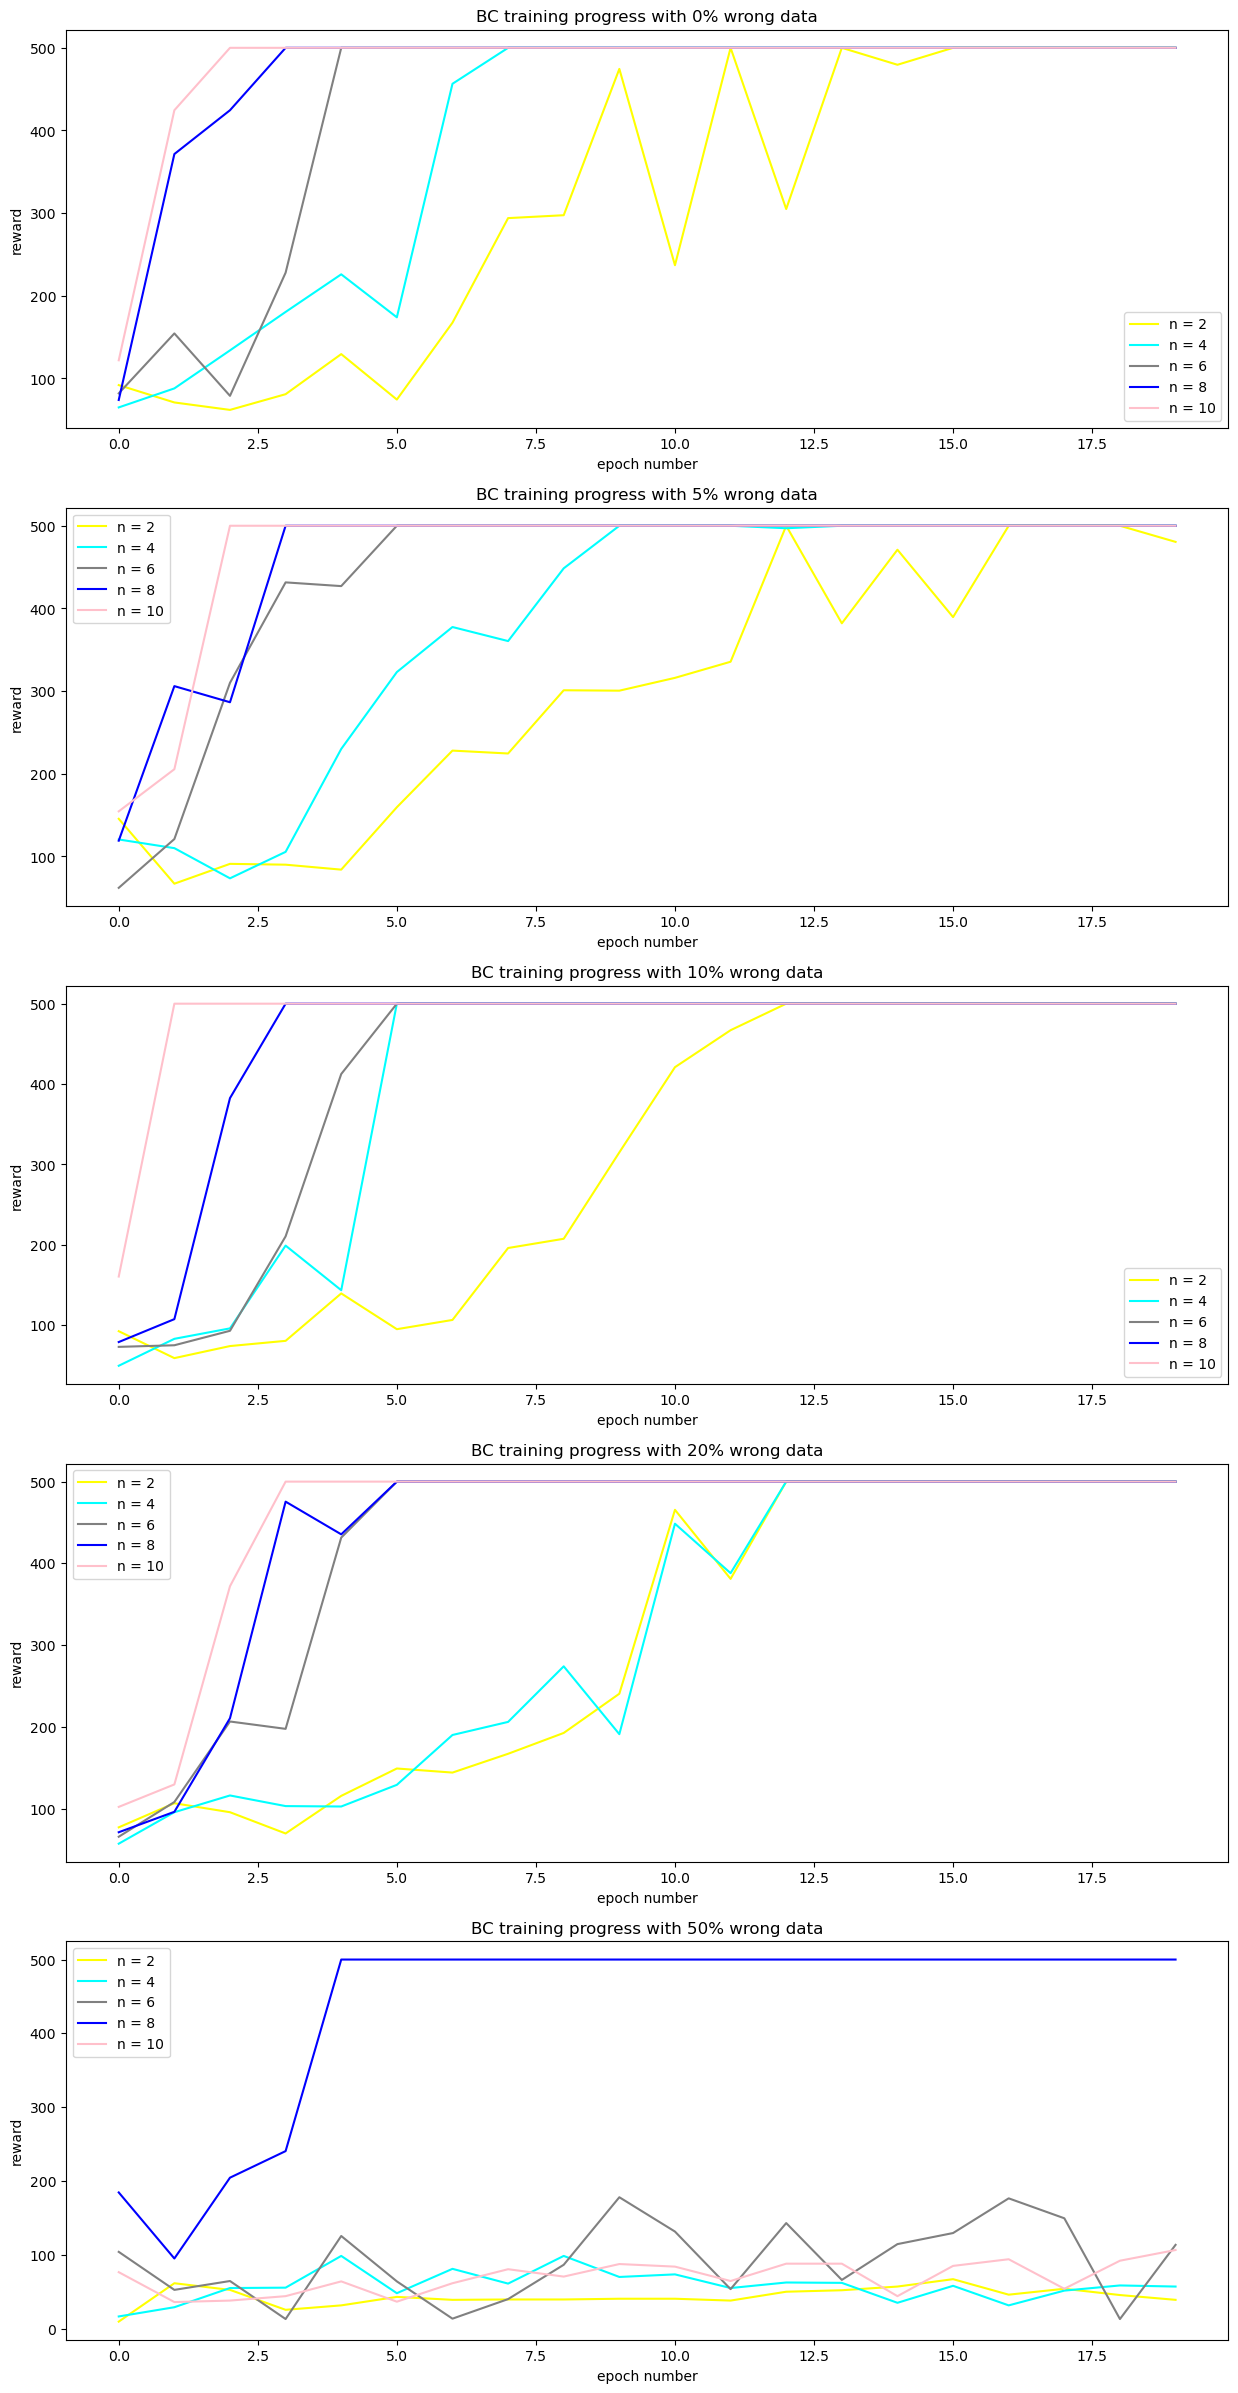

In [235]:
plt.figure(figsize=[15,30])

for j,i in enumerate(trainers):
    plt.subplot(5,1,j+1)
    plt.title(f'BC training progress with {i}% wrong data')
    plt.xlabel('epoch number')
    plt.ylabel('reward')
    plt.plot(RW[i][0], color='yellow', label="n = 2")
    plt.plot(RW[i][1], color='cyan', label="n = 4")
    plt.plot(RW[i][2], color='gray', label="n = 6")
    plt.plot(RW[i][3], color='blue', label="n = 8")
    plt.plot(RW[i][4], color='pink', label="n = 10")
    plt.legend()


# DAgger

In [176]:
rollouts_0 = copy.deepcopy(rollouts)
rollouts_5 = copy.deepcopy(rollouts)
rollouts_10 = copy.deepcopy(rollouts)
rollouts_20 = copy.deepcopy(rollouts)
rollouts_50 = copy.deepcopy(rollouts)

toggl_acts(rollouts_5, 0.05)
toggl_acts(rollouts_10, 0.1)
toggl_acts(rollouts_20, 0.2)
toggl_acts(rollouts_50, 0.5)


In [168]:
def aggregate_rollout(bc_rollout, policy, i):

    agent_rollout = rollout.rollout(
        policy,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=2),
        rng=rng,
    )

    agent_rollout = random.sample(agent_rollout, i)
    new_rollout = agent_rollout + bc_rollout
    return new_rollout



In [227]:
def DAgger(trainer, beta):

    if random.random() < beta :
        global rolls
        rolls[trainer] = aggregate_rollout(rolls[trainer][:], bc_trainers[trainer].policy, 1)
        # print(len(rolls[trainer]))
    
    rewards.append(evaluate_policy(bc_trainers[trainer].policy, env, 2)[0].mean())
    


In [221]:
DAgger(0, 1)
len(rolls[0])

7

In [229]:
N = [2, 4 ,6, 8, 10]
trainers = [0, 5, 10, 20, 50]
rewards = []

RW = {0: [], 5: [], 10:[], 20:[], 50:[]}

beta = 0.5

for n in N:

    global rolls
    rolls = {0: random.sample(rollouts_0, n),
         5: random.sample(rollouts_5, n), 
         10: random.sample(rollouts_10, n), 
         20: random.sample(rollouts_20, n), 
         50: random.sample(rollouts_50, n)}

    bc_trainers = create_BC_trainers(n)
    
    for trainer in trainers :

        bc_trainers[trainer].set_demonstrations(get_transitions(rolls[trainer], -1))
        
        rewards = []
        bc_trainers[trainer].train( 
            n_epochs=20, 
            progress_bar= False, 
            on_epoch_end= lambda : DAgger(trainer, beta),
            log_interval=10000
            )
        
        RW[trainer].append(rewards)
        



---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------
---------------------------------
| batch_size  

In [230]:
len(rolls[5])

26

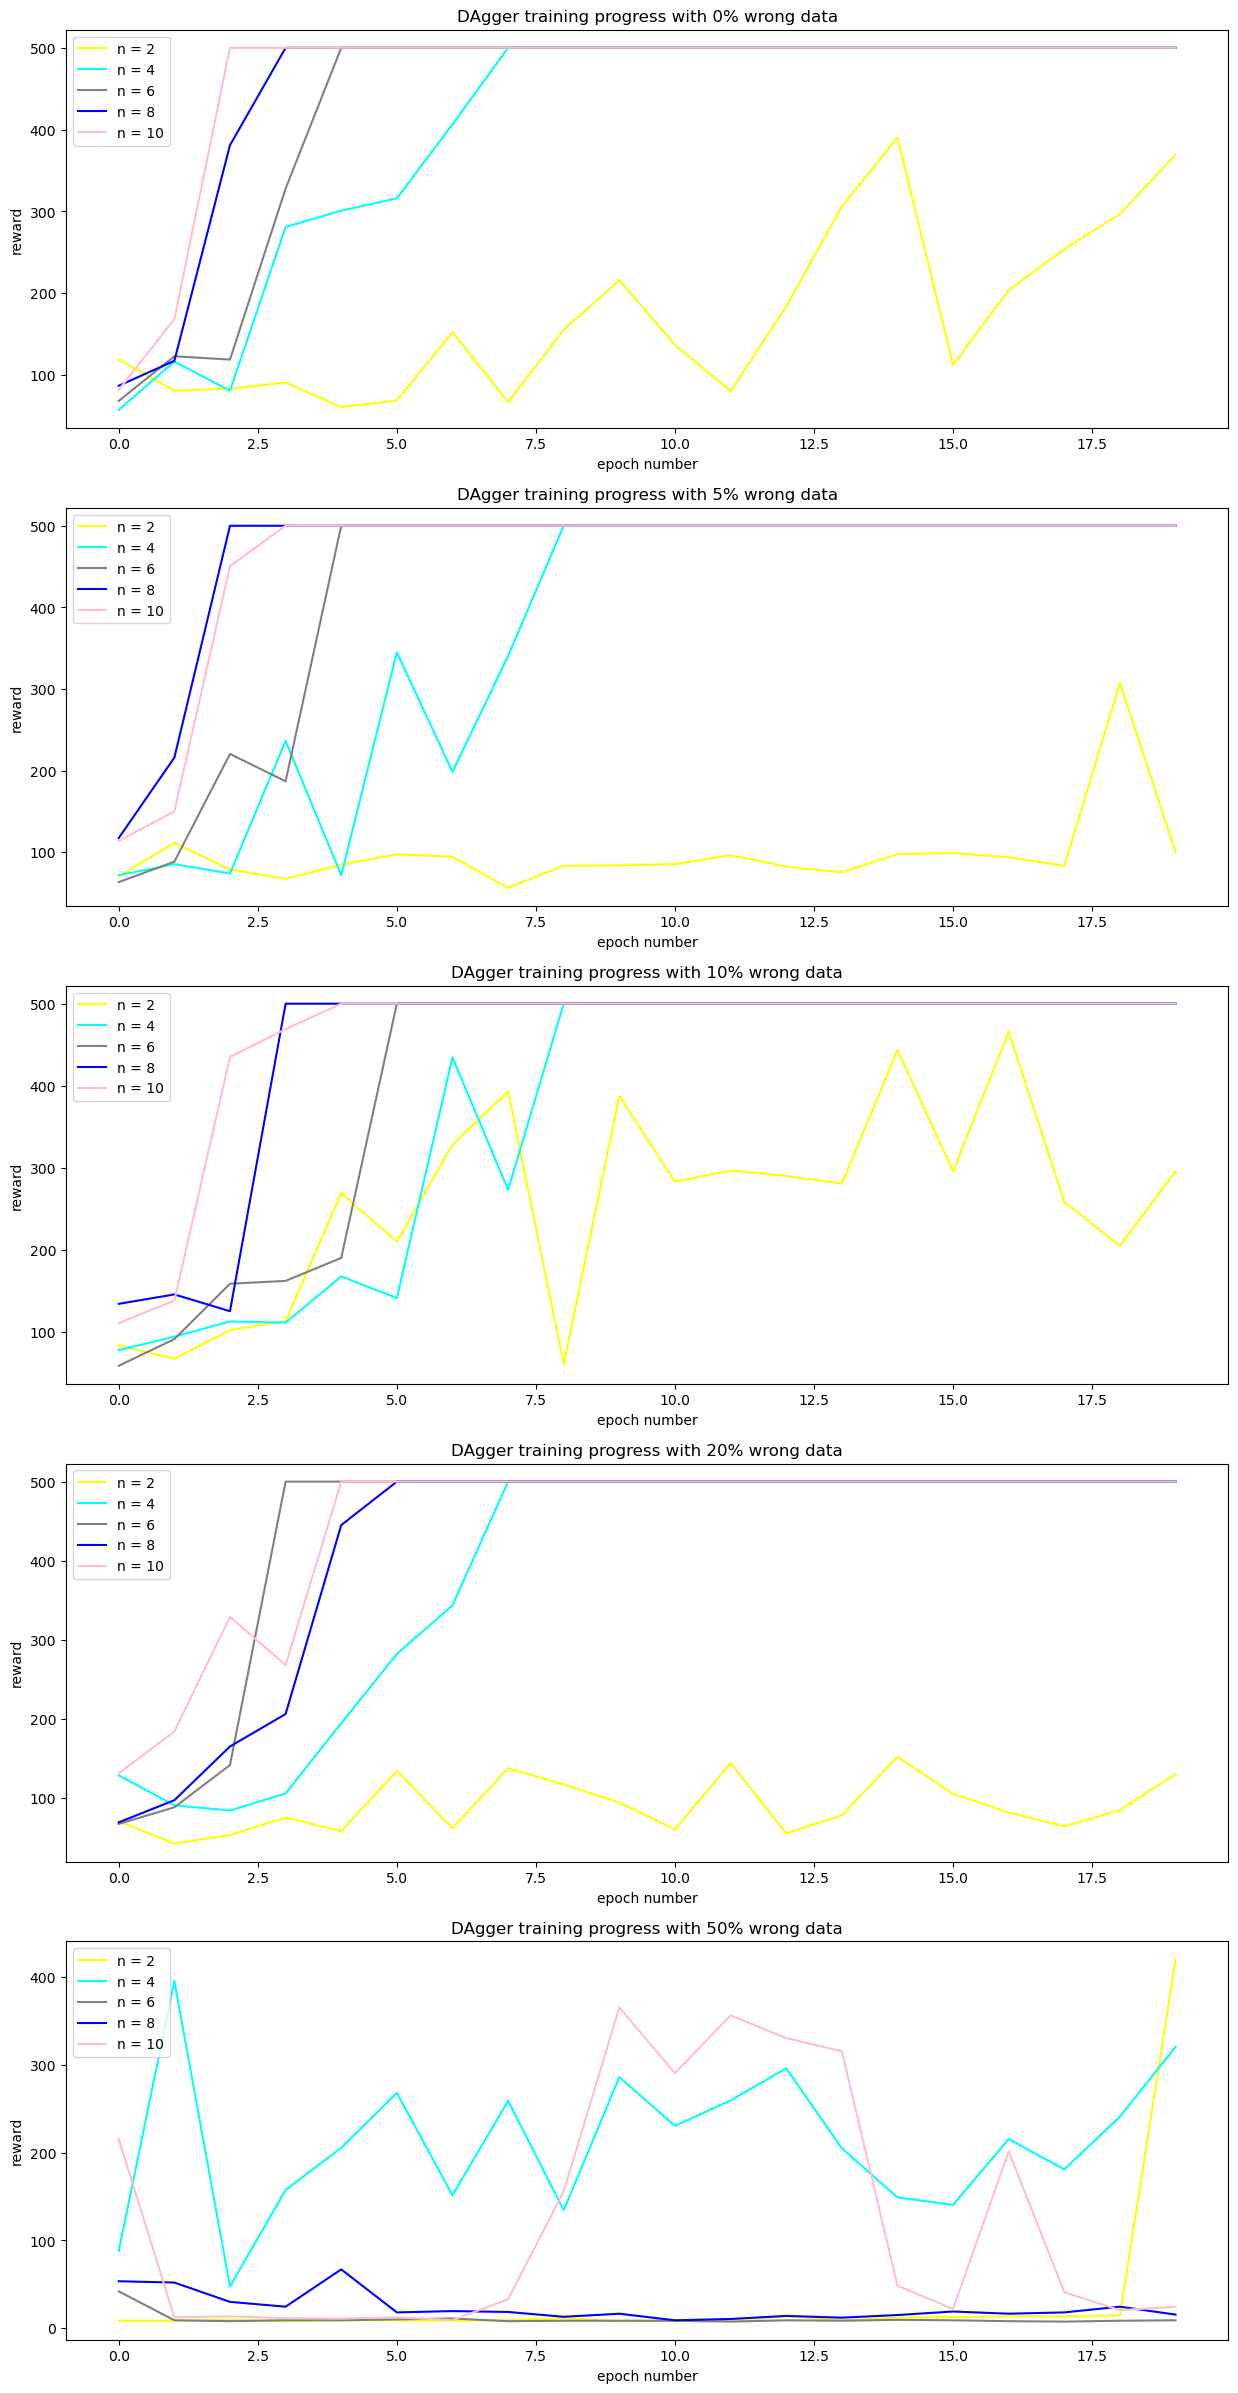

In [232]:
plt.figure(figsize=[15,30])

for j,i in enumerate(trainers):
    plt.subplot(5,1,j+1)
    plt.title(f'DAgger training progress with {i}% wrong data')
    plt.xlabel('epoch number')
    plt.ylabel('reward')
    plt.plot(RW[i][0], color='yellow', label="n = 2")
    plt.plot(RW[i][1], color='cyan', label="n = 4")
    plt.plot(RW[i][2], color='gray', label="n = 6")
    plt.plot(RW[i][3], color='blue', label="n = 8")
    plt.plot(RW[i][4], color='pink', label="n = 10")

    plt.legend()


In [ ]:
def evaluate_rollout():
    

In [ ]:
def aggregate_rollout2(bc_rollout, policy, expert, i):

    agent_rollout = rollout.rollout(
        policy,
        env,
        rollout.make_sample_until(min_timesteps=None, min_episodes=2),
        rng=rng,
    )

    score = evaluate_rollout(agent_rollout, expert,)

    agent_rollout = random.sample(agent_rollout, i)
    new_rollout = agent_rollout + bc_rollout
    return new_rollout


In [353]:
class PolicyWrapper:
    def __init__(self, original_policy, env, acc):
        self.original_policy = original_policy
        self.env = env
        self.acc = acc

    def predict(self, *args):
        x = self.original_policy.predict(*args)
        w = x[0]

        k = len(w)
        nbr_of_act = int(k * (1-self.acc))
        action_to_toggl = random.sample(range(k), nbr_of_act)
        w[action_to_toggl] = 1 - w[action_to_toggl]
        out = (w, x[1])
        return out
       
    def __getattr__(self, name):
        return getattr(self.original_policy, name)


wrapped_policy = PolicyWrapper(expert, env, 0.9)

In [352]:
len(wrapped_policy.predict(rollouts[0].obs)[0])

501

In [365]:
sum((rollouts[1].acts[0] - wrapped_policy.predict(rollouts[1].obs)[0])**2)

86

array([[-2.8108327e-02,  4.3989941e-02,  1.1769248e-02, -3.4125257e-02],
       [-2.7228527e-02, -1.5129879e-01,  1.1086743e-02,  2.6224762e-01],
       [-3.0254504e-02, -3.4657723e-01,  1.6331695e-02,  5.5840671e-01],
       ...,
       [-4.4957596e+02, -9.0781273e+01, -2.3548982e+00, -1.0273348e+01],
       [-4.5139157e+02, -9.1046730e+01, -2.5603652e+00, -1.0762703e+01],
       [-4.5321249e+02, -9.1304787e+01, -2.7756193e+00, -1.1247648e+01]],
      dtype=float32)